In [1]:
! pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


In [2]:
! pip install geodatasets

Defaulting to user installation because normal site-packages is not writeable


In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from geodatasets import get_path

# Create results folder if it doesn't exist
results_folder = "results"
os.makedirs(results_folder, exist_ok=True)

# File paths
constrained_path = '7_original_tau_567.npy'
unconstrained_path = '7_original_tau_none.npy'

# Load data
optimal_interventions_constrained = np.load(constrained_path)
optimal_interventions_unconstrained = np.load(unconstrained_path)
school_df = pd.read_csv('features.csv')
neighbor_index_matrix = np.load('neighbor_index_matrix.npy')
neighbor_distance_matrix = np.load('neighbor_distance_matrix.npy')

# Constants
NUM_SCHOOLS = school_df.shape[0]
race_columns = ['n_A', 'n_B', 'n_C', 'n_D', 'n_E', 'n_F', 'n_G']

# Add majority race column
school_df['majority_race'] = school_df[race_columns].idxmax(axis=1)
school_df['majority_race'] = school_df['majority_race'].str[2:]  # Remove 'n_' prefix

# Generate random interventions with the same count as Constrained Tau
num_random_interventions = optimal_interventions_constrained.sum()
random_interventions = np.zeros(NUM_SCHOOLS, dtype=int)
random_indices = np.random.choice(NUM_SCHOOLS, size=num_random_interventions, replace=False)
random_interventions[random_indices] = 1

print(f"Constrained Tau Interventions: {optimal_interventions_constrained.sum()}")
print(f"Unconstrained Tau Interventions: {optimal_interventions_unconstrained.sum()}")
print(f"Random Interventions: {random_interventions.sum()}")

Constrained Tau Interventions: 100
Unconstrained Tau Interventions: 100
Random Interventions: 100


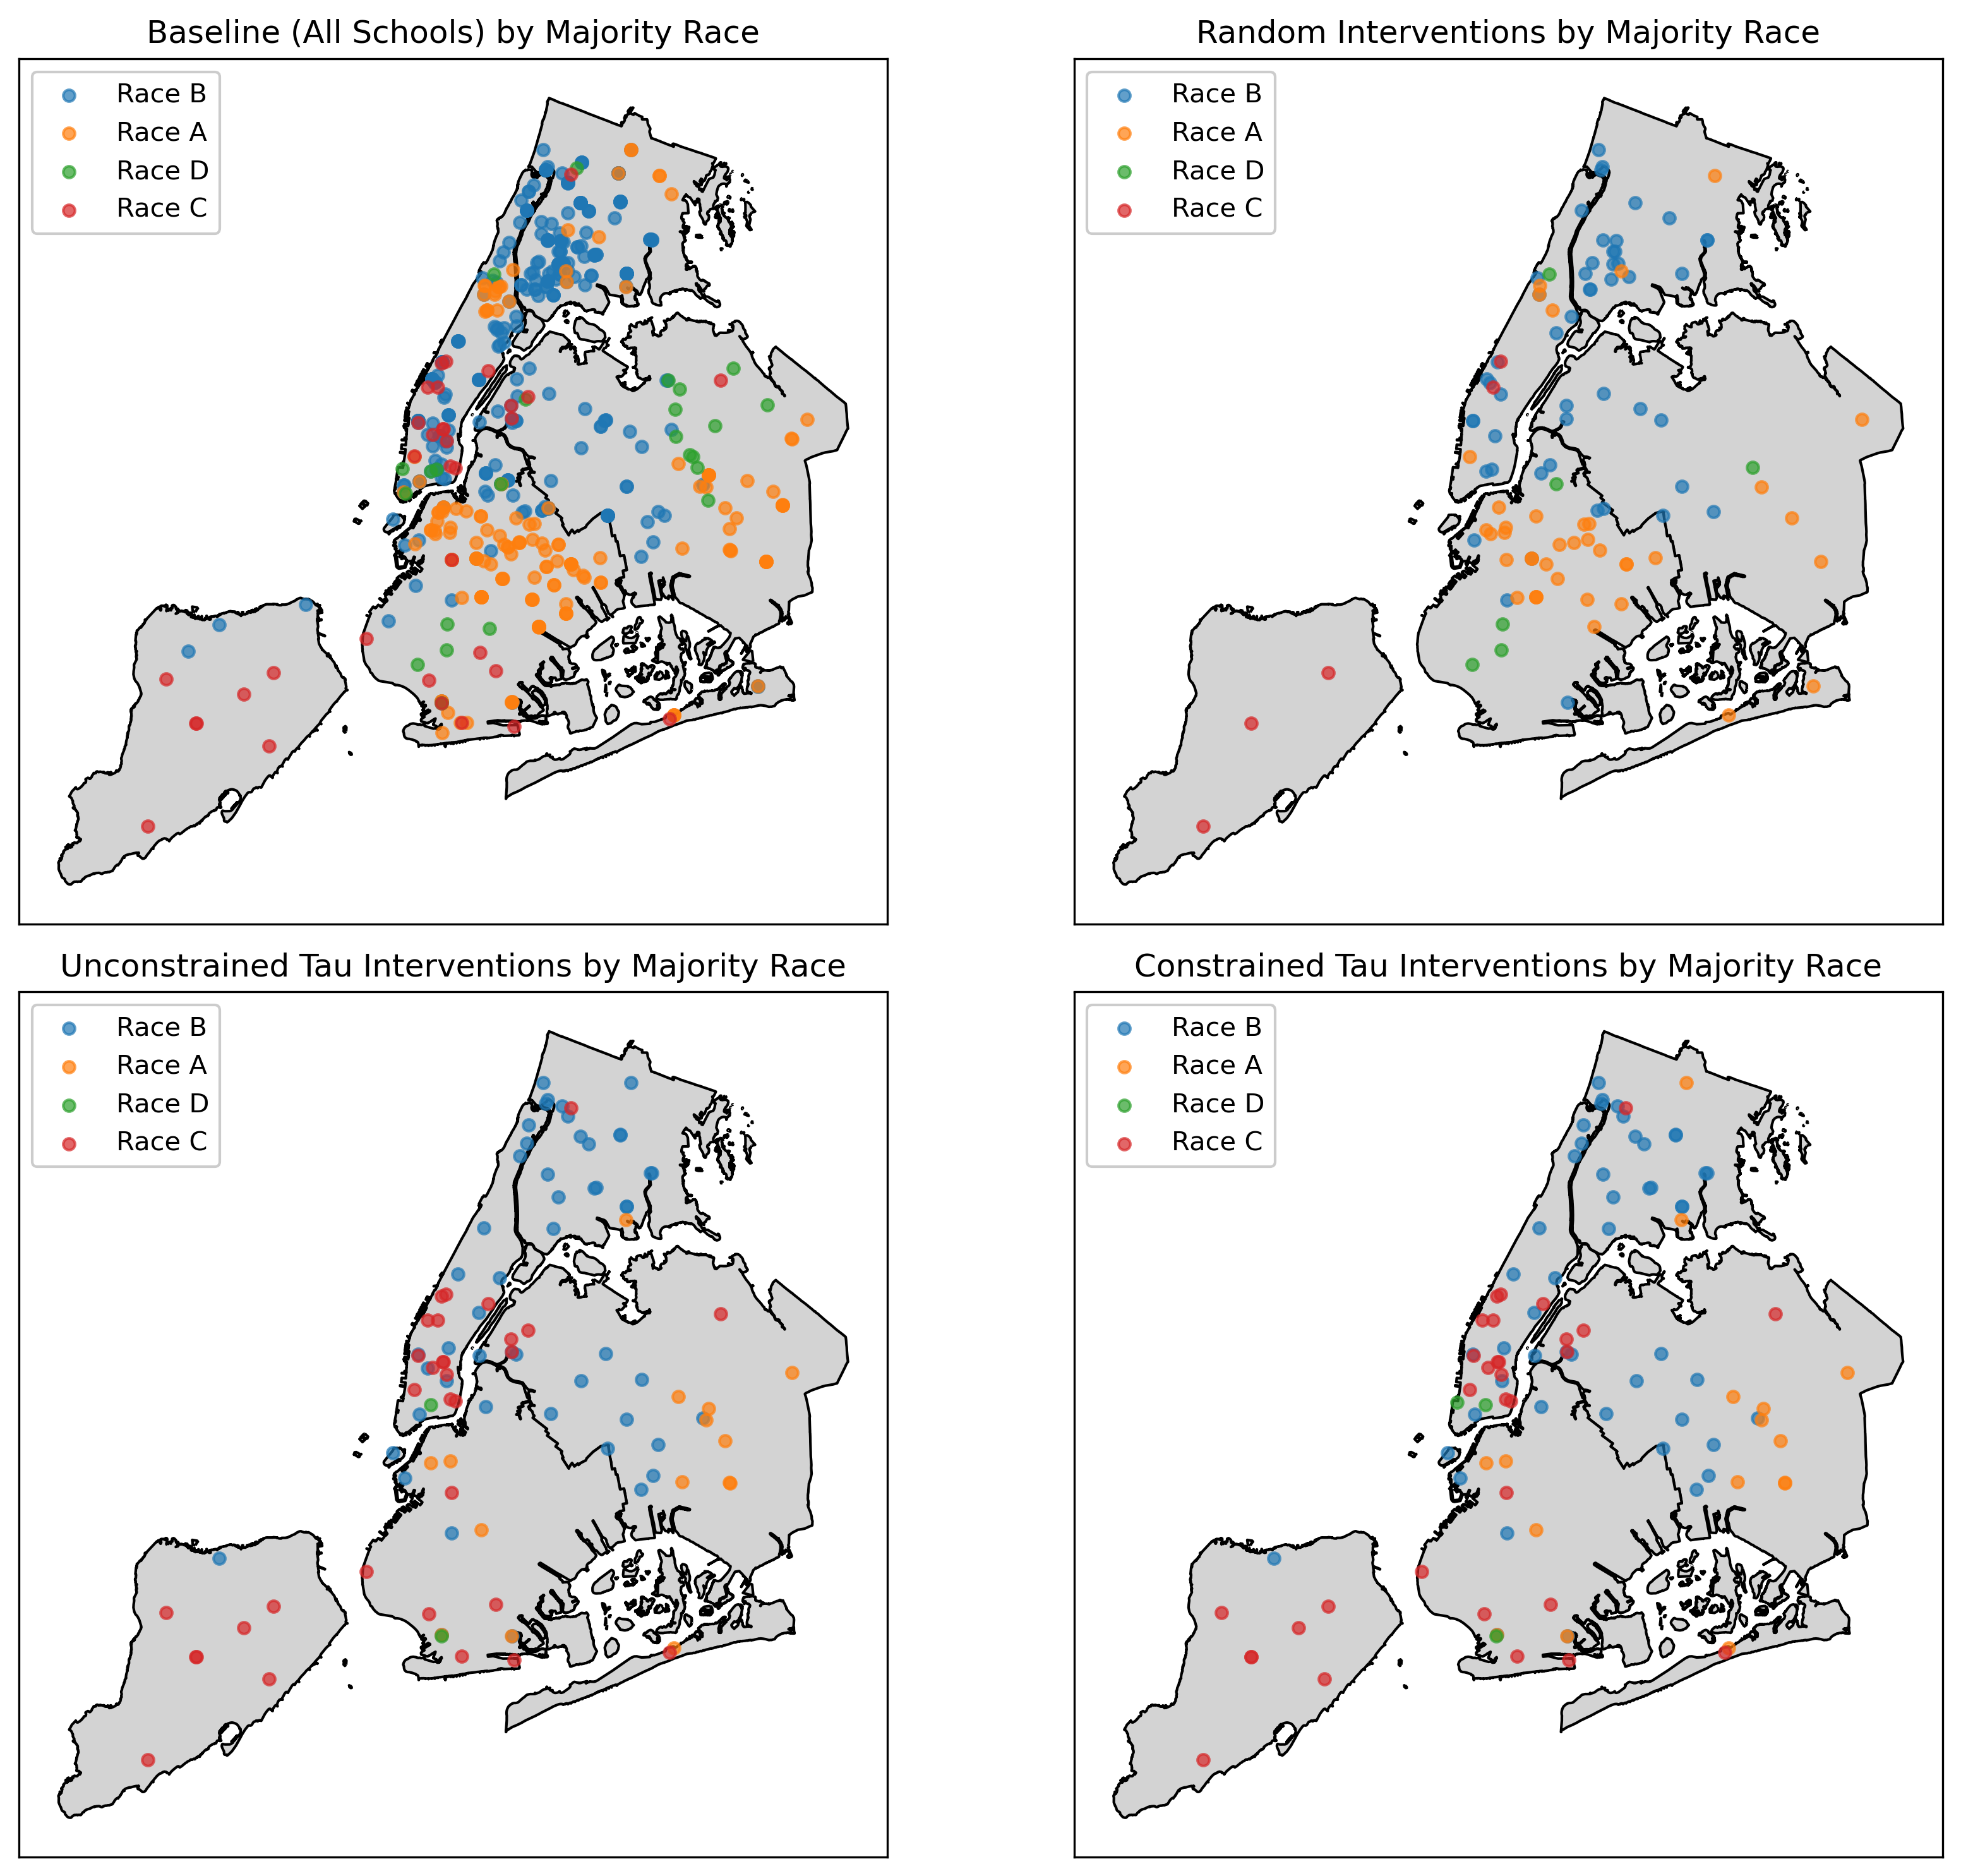

Combined map plot saved to results/intervention_maps_comparison.png
The map visualization compares four intervention strategies:
1. Baseline: All schools without interventions, showing the majority race distribution.
2. Random Interventions: Randomly selected schools with interventions.
3. Unconstrained Tau: Schools chosen for interventions under an unconstrained strategy.
4. Constrained Tau: Schools chosen for interventions under a constrained strategy.
Each map highlights the distribution of majority races (Race A, B, etc.) for the respective intervention strategy.


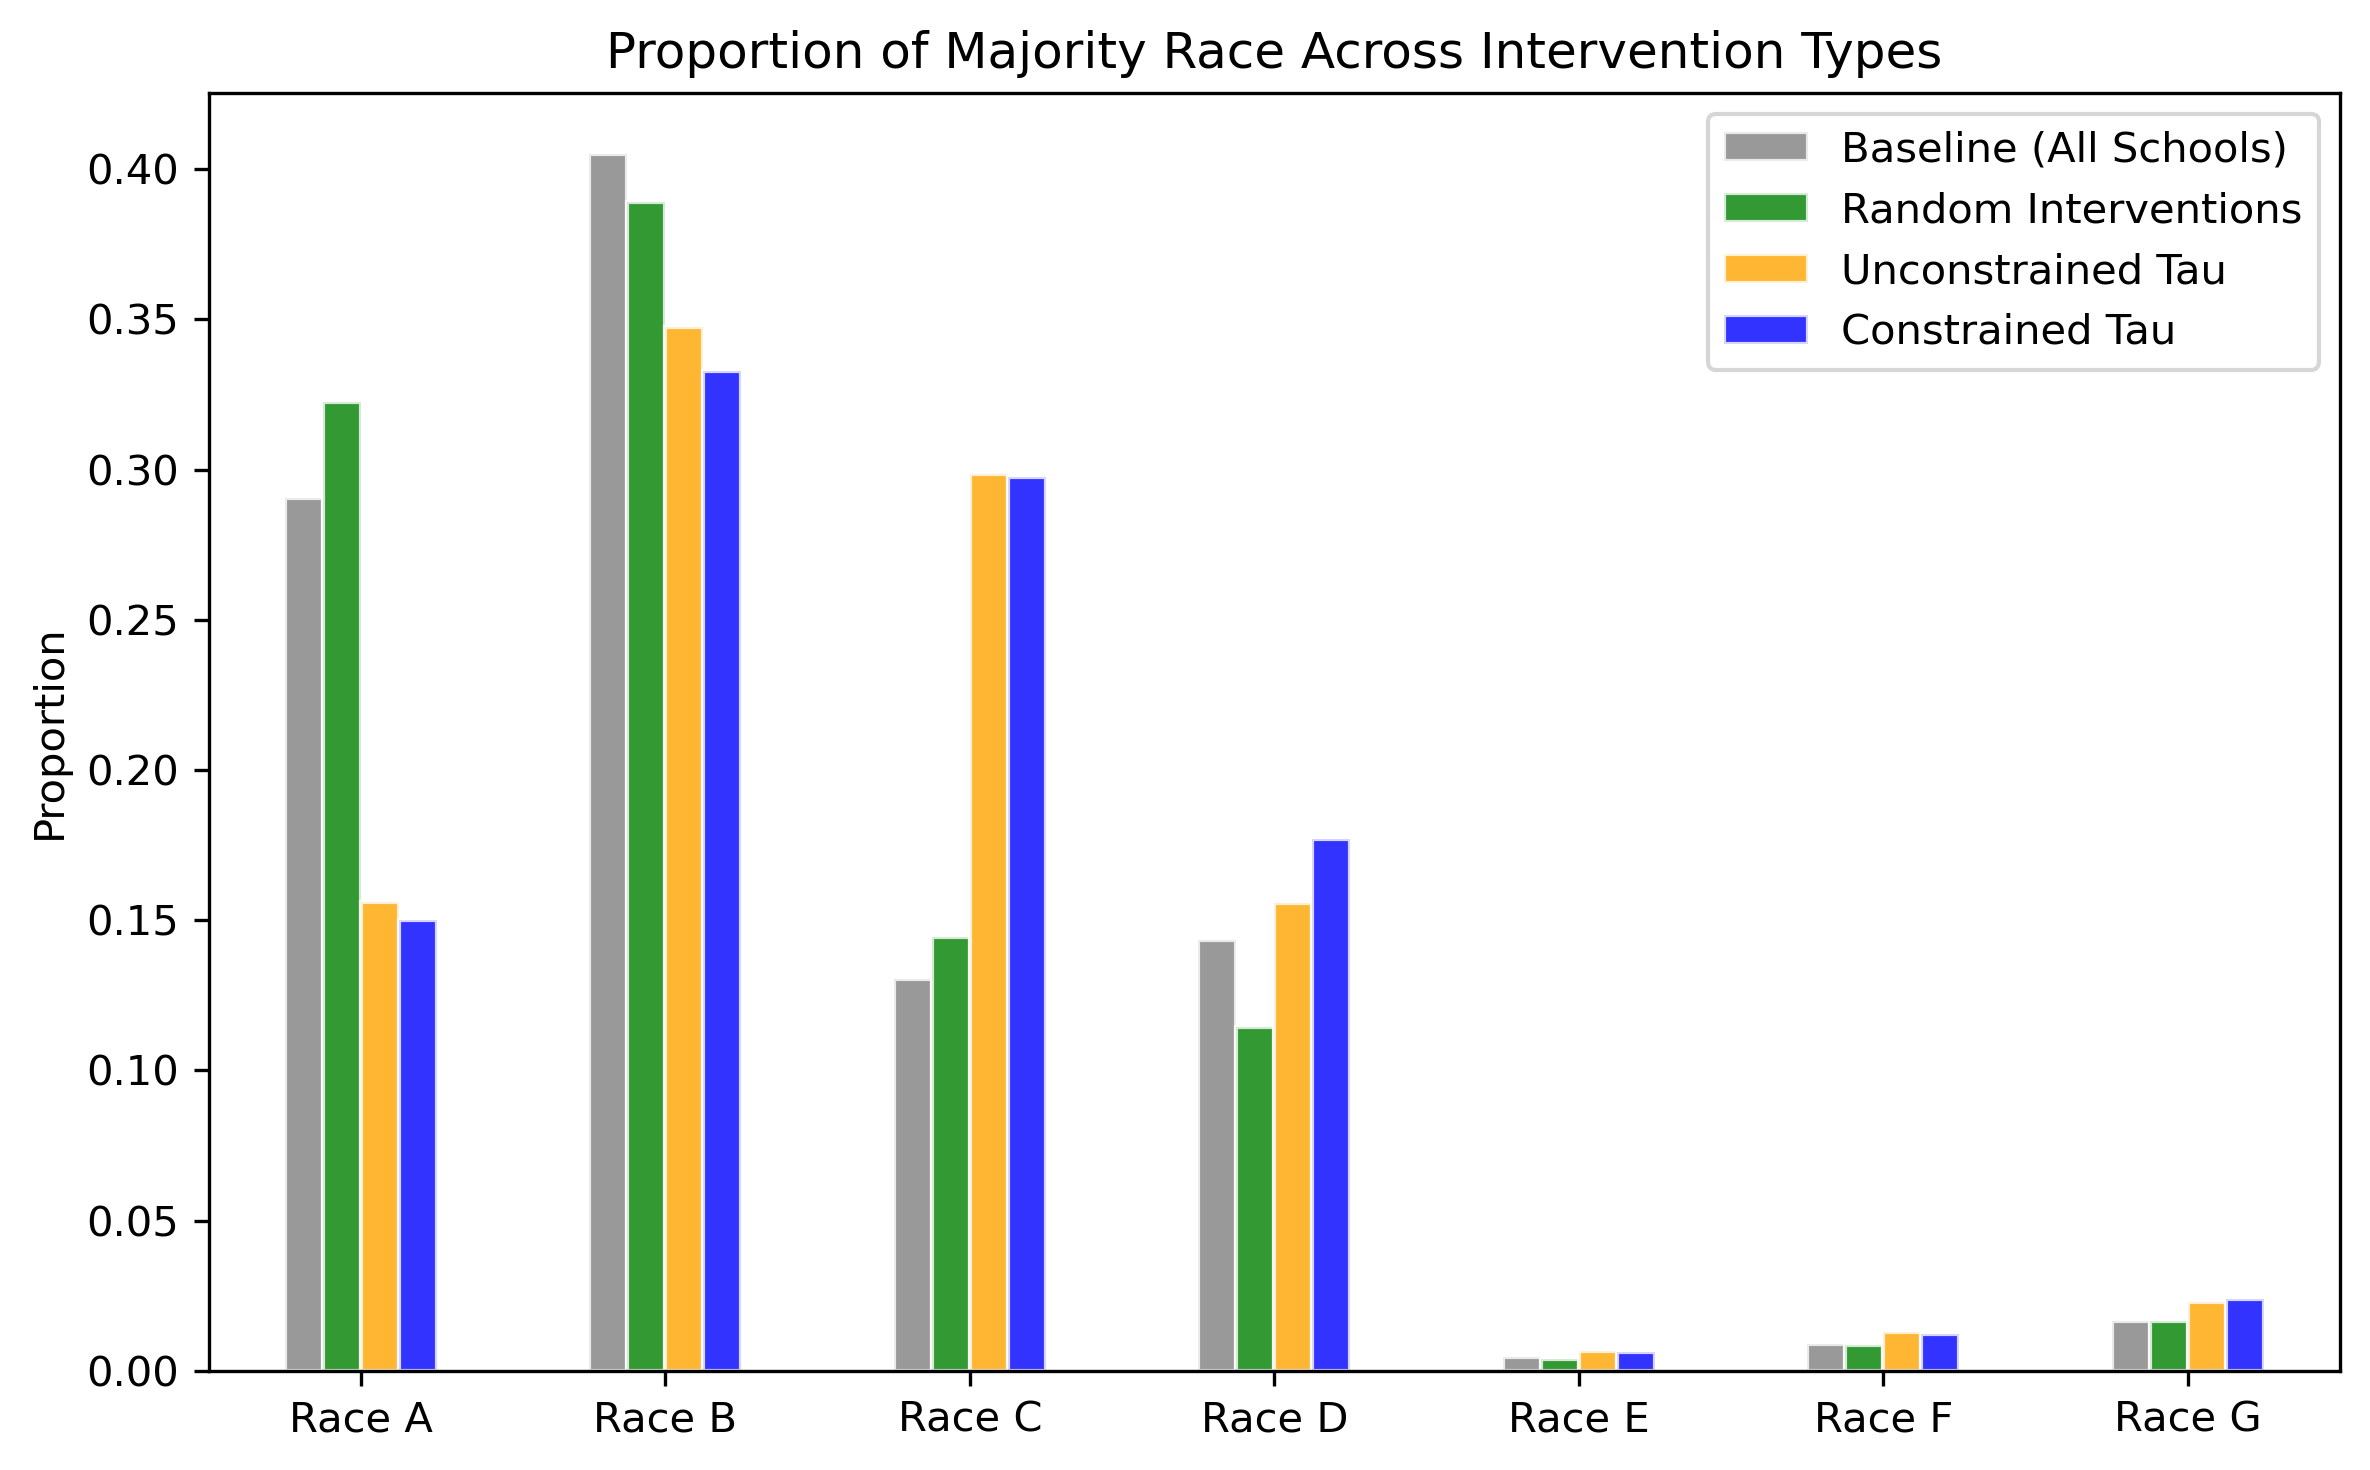

Race proportions comparison plot saved to results/race_proportions_comparison.png
The bar chart visualizes the proportions of majority races (Race A, B, etc.) across four strategies:
1. Baseline: Distribution for all schools.
2. Random Interventions: Distribution for randomly selected intervention schools.
3. Unconstrained Tau: Distribution for schools chosen under an unconstrained strategy.
4. Constrained Tau: Distribution for schools chosen under a constrained strategy.
This chart highlights the variation in racial distribution for each intervention strategy.


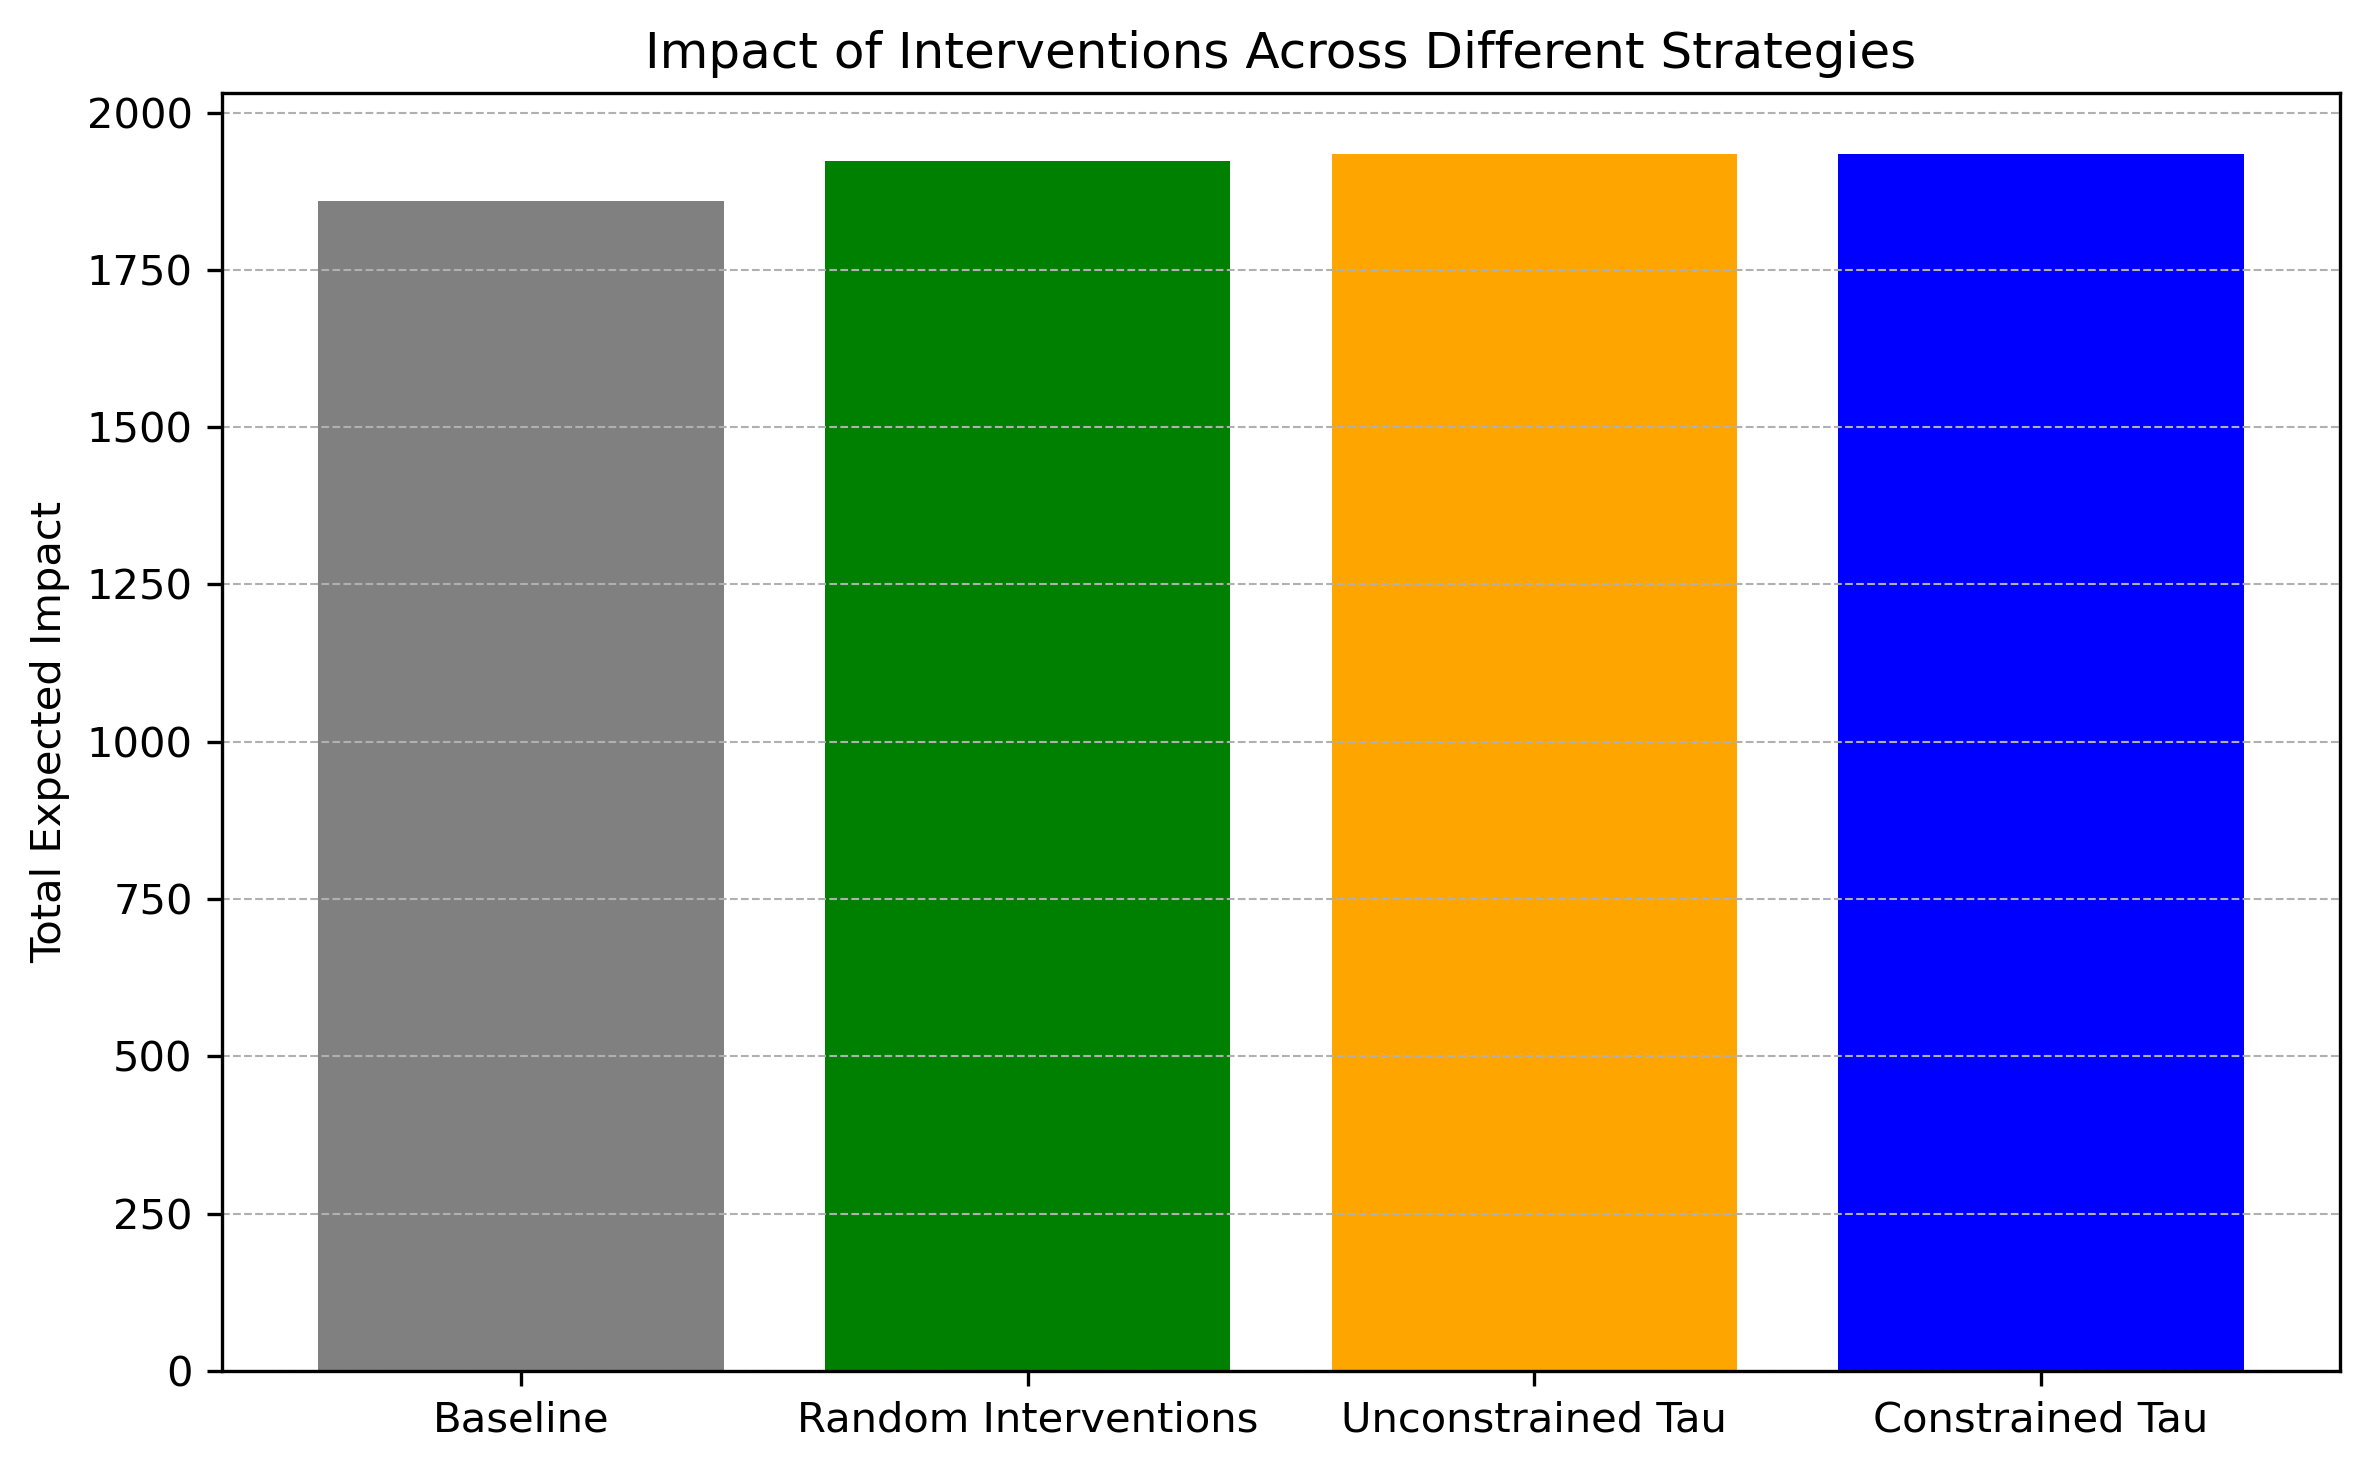

Impact comparison plot saved to results/impact_comparison.png
The impact plot compares the total expected impact for four intervention strategies:
1. Baseline: Impact with no interventions applied.
2. Random Interventions: Impact when interventions are randomly assigned.
3. Unconstrained Tau: Impact under an unconstrained intervention strategy.
4. Constrained Tau: Impact under a constrained intervention strategy.
This plot quantifies the effectiveness of each strategy in improving total expected impact.


In [12]:
# Separate schools into unique and common groups
all_schools_baseline = school_df
unique_to_random = school_df[random_interventions == 1]
unique_to_unconstrained = school_df[optimal_interventions_unconstrained == 1]
unique_to_constrained = school_df[optimal_interventions_constrained == 1]

# Function to plot a single map
def plot_map(ax, title, schools):
    boroughs = gpd.read_file(get_path("nybb")).to_crs("EPSG:4326")
    boroughs.plot(ax=ax, color='lightgray', edgecolor='black')
    for race in school_df['majority_race'].unique():
        data = schools[schools['majority_race'] == race]
        ax.scatter(data['longitude'], data['latitude'], label=f"Race {race[-1]}", alpha=0.7, s=20)
    ax.set_title(title)
    ax.legend(loc='upper left', framealpha=1)
    ax.set_xticks([])
    ax.set_yticks([])

# Combined map plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), dpi=300)
axes = axes.ravel()

plot_map(axes[0], "Baseline (All Schools) by Majority Race", all_schools_baseline)
plot_map(axes[1], "Random Interventions by Majority Race", unique_to_random)
plot_map(axes[2], "Unconstrained Tau Interventions by Majority Race", unique_to_unconstrained)
plot_map(axes[3], "Constrained Tau Interventions by Majority Race", unique_to_constrained)

plt.tight_layout()
combined_map_path = os.path.join(results_folder, "intervention_maps_comparison.png")
plt.savefig(combined_map_path)
plt.show()
print(f"Combined map plot saved to {combined_map_path}")

# Detailed description for the combined map plot
print(
    "The map visualization compares four intervention strategies:\n"
    "1. Baseline: All schools without interventions, showing the majority race distribution.\n"
    "2. Random Interventions: Randomly selected schools with interventions.\n"
    "3. Unconstrained Tau: Schools chosen for interventions under an unconstrained strategy.\n"
    "4. Constrained Tau: Schools chosen for interventions under a constrained strategy.\n"
    "Each map highlights the distribution of majority races (Race A, B, etc.) for the respective intervention strategy."
)

# Bar plots for race proportions
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Race proportion calculations
baseline_counts = all_schools_baseline[race_columns].sum(axis=0)
baseline_freq = baseline_counts / baseline_counts.sum()

random_counts = unique_to_random[race_columns].sum(axis=0)
random_freq = random_counts / random_counts.sum()

unconstrained_counts = unique_to_unconstrained[race_columns].sum(axis=0)
unconstrained_freq = unconstrained_counts / unconstrained_counts.sum()

constrained_counts = unique_to_constrained[race_columns].sum(axis=0)
constrained_freq = constrained_counts / constrained_counts.sum()

# Combine data for plotting
race_df = pd.concat(
    (baseline_freq, random_freq, unconstrained_freq, constrained_freq),
    axis=1
)
race_df.columns = ['Baseline (All Schools)', 'Random Interventions', 'Unconstrained Tau', 'Constrained Tau']
race_df.index = [f"Race {col[-1]}" for col in race_columns]

# Plot bar chart
race_df.plot.bar(ax=ax, rot=0, color=['gray', 'green', 'orange', 'blue'], edgecolor='white', alpha=0.8)
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Majority Race Across Intervention Types')
plt.legend(loc='upper right')
plt.tight_layout()

# Show plot and save it
bar_plot_path = os.path.join(results_folder, "race_proportions_comparison.png")
plt.savefig(bar_plot_path)
plt.show()
print(f"Race proportions comparison plot saved to {bar_plot_path}")

# Detailed description for the bar plot
print(
    "The bar chart visualizes the proportions of majority races (Race A, B, etc.) across four strategies:\n"
    "1. Baseline: Distribution for all schools.\n"
    "2. Random Interventions: Distribution for randomly selected intervention schools.\n"
    "3. Unconstrained Tau: Distribution for schools chosen under an unconstrained strategy.\n"
    "4. Constrained Tau: Distribution for schools chosen under a constrained strategy.\n"
    "This chart highlights the variation in racial distribution for each intervention strategy."
)

# Impact plot

# Calculate impacts
baseline_impact = total_impact(null_array)
random_impact = total_impact(random_interventions)
unconstrained_impact = total_impact(optimal_interventions_unconstrained)
constrained_impact = total_impact(optimal_interventions_constrained)

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
labels = ['Baseline', 'Random Interventions', 'Unconstrained Tau', 'Constrained Tau']
values = [baseline_impact, random_impact, unconstrained_impact, constrained_impact]

ax.bar(labels, values, color=['gray', 'green', 'orange', 'blue'])
ax.set_ylabel('Total Expected Impact')
ax.set_title('Impact of Interventions Across Different Strategies')
ax.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

impact_plot_path = os.path.join(results_folder, "impact_comparison.png")
plt.savefig(impact_plot_path)
plt.show()
print(f"Impact comparison plot saved to {impact_plot_path}")

# Detailed description for the impact plot
print(
    "The impact plot compares the total expected impact for four intervention strategies:\n"
    "1. Baseline: Impact with no interventions applied.\n"
    "2. Random Interventions: Impact when interventions are randomly assigned.\n"
    "3. Unconstrained Tau: Impact under an unconstrained intervention strategy.\n"
    "4. Constrained Tau: Impact under a constrained intervention strategy.\n"
    "This plot quantifies the effectiveness of each strategy in improving total expected impact."
)
